## Summary of the notebook

**train configuration** <br> 
eager execution = enabled 

**process** 
1. Define the model and fit the model using train, validation and test data 
2. Save the trained model at specified path 
3. Use the trained model variable and pass it to the StochasticRegressor class 
4. From the object/model returned in 3., access the predict_output() by passing the test data and the number of samples to be taken (to provide the regression output). This function returns the output samples, pred mean and pred std 
5. Plot the prediction mean and +-1 std dev against the ground truth to visualize the performances of the model 

**critical points and checklist** 
1. the script should yield a trained model 
2. pdfs and pngs in the output plot folder 
3. check model training configuration once (the loss, optimizer, architecture, metrics etc) 

**analysis**
1. for num_samples = 20 and a single input record (of shape(1, 8)) <br> 
intermediate samples shape : (20, 1, 1) <br> 
final mean and std/var shape : (1, 1)


## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting the correct path

In [2]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'flipout'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/


## Removing previous trained models

In [3]:
list_of_files = os.listdir(path)
print(path)

for item in list_of_files:
    if item.endswith('.h5'):
        print(f'deleting {path+item}')
        os.remove(os.path.join(path, item))

/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/
deleting /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/flipout_model_epochs_500_num_samples_20.h5


## Imports

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.2
Eager execution enabled : True


## Installing keras uncertainty

## Load data

In [5]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()

# check to ensure the functionality of load function 
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class and distribution definitions

### StochasticModel & StochasticRegressor

In [6]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K 

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate samples shape ', samples.shape)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return samples, mean_pred, std_pred 

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

### Gaussian and Rademacher distribution

In [7]:
# rademacher 
import tensorflow.keras.backend as K

def sample(shape):
    samples = K.random_binomial(shape, p=0.5)

    return 2.0 * samples - 1.0


# gaussian 
import numpy as np
import math

NegHalfLog2PI = -0.5 * math.log(2.0 * math.pi)
InvSqrt2PI = 1.0 / (math.sqrt(2.0 * math.pi))

def log_probability(x, mu, sigma):
    return NegHalfLog2PI - K.log(sigma) - 0.5 * K.square((x - mu) / sigma)

def probability(x, mu, sigma):
    x= K.square((x - mu) / sigma)

    return InvSqrt2PI * (1.0 / sigma) * K.exp(-0.5 * x)

class GaussianDistribution:
    def __init__(self, mean, std, shape):
        self.mean = mean
        self.std = std
        self.shape = shape

    def sample(self):
        return K.random_normal(self.shape, self.mean, self.std)

    def sample_perturbation(self):
        return K.random_normal(self.shape, K.zeros(self.shape), self.std)

    def log_probability(self, x):
        return NegHalfLog2PI - K.log(self.std) - 0.5 * K.square((x - self.mean) / self.std)

### FlipoutDense

In [8]:
import numpy as np
import tensorflow
import keras
Layer = tensorflow.keras.layers.Layer
activations = tensorflow.keras.activations
initializers = keras.initializers

#from keras_uncertainty.distributions import gaussian, rademacher

# Code partially based on http://krasserm.github.io/2019/03/14/bayesian-neural-networks/

class FlipoutDense(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 initializer_sigma=0.1,
                 prior=True,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,
                 bias_distribution=False,
                  **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior = prior
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.initializer_sigma = initializer_sigma
        self.uses_learning_phase = True
        self.bias_distribution = bias_distribution

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return [(None, self.units)]

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.initializer_sigma),
                                         trainable=True)
        
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                          trainable=True)

        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.initializer_sigma),
                                       trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                        trainable=self.bias_distribution)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = K.softplus(self.kernel_rho)
        kernel_perturb = kernel_sigma * K.random_normal(self.kernel_mu.shape)
        kernel = self.kernel_mu + kernel_perturb

        if self.bias_distribution:
            bias_sigma = K.softplus(self.bias_rho)
            bias = self.bias_mu + bias_sigma * K.random_normal(self.bias_mu.shape)
        else:
            bias = self.bias_mu

        loss = self.kl_loss(kernel, self.kernel_mu, kernel_sigma)

        if self.bias_distribution:
            loss += self.kl_loss(bias, self.bias_mu, bias_sigma)

        self.add_loss(K.in_train_phase(loss, 0.0))

        input_shape = K.shape(inputs)
        batch_shape = input_shape[:-1]
        sign_input = sample(input_shape)
        sign_output = sample(K.concatenate([batch_shape, K.expand_dims(self.units, 0)], axis=0))
        perturbed_inputs = K.dot(inputs * sign_input, kernel_perturb) * sign_output

        outputs = K.dot(inputs, self.kernel_mu)
        outputs += perturbed_inputs
        outputs += bias

        # This always produces stochastic outputs
        return self.activation(outputs)

    def kl_loss(self, w, mu, sigma):
        return self.kl_weight * K.mean(log_probability(w, mu, sigma) - self.prior * self.log_prior_prob(w))

    def log_prior_prob(self, w):
        return K.log(self.prior_pi_1 * probability(w, 0.0, self.prior_sigma_1) +
                     self.prior_pi_2 * probability(w, 0.0, self.prior_sigma_2))

    def get_config(self):
        config = {'units': self.units,
                  'kl_weight': self.kl_weight,
                  'activation': self.activation.__name__,
                  #'bias': self.bias,
                  'prior': self.prior,
                  'prior_sigma_1': self.prior_sigma_1,
                  'prior_sigma_2': self.prior_sigma_2,
                  'prior_pi_1': self.prior_pi_1}
        base_config = super(FlipoutDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Define and train Flipout model

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


2/2 - 9s - loss: 0.2004 - mae: 0.3703 - val_loss: 0.1556 - val_mae: 0.3113 - 9s/epoch - 4s/step
Epoch 2/500
2/2 - 0s - loss: 0.1067 - mae: 0.2331 - val_loss: 0.1098 - val_mae: 0.2432 - 102ms/epoch - 51ms/step
Epoch 3/500
2/2 - 0s - loss: 0.1143 - mae: 0.2408 - val_loss: 0.1305 - val_mae: 0.2736 - 155ms/epoch - 77ms/step
Epoch 4/500
2/2 - 0s - loss: 0.1125 - mae: 0.2398 - val_loss: 0.1623 - val_mae: 0.3210 - 158ms/epoch - 79ms/step
Epoch 5/500
2/2 - 0s - loss: 0.1019 - mae: 0.2228 - val_loss: 0.1448 - val_mae: 0.2957 - 139ms/epoch - 70ms/step
Epoch 6/500
2/2 - 0s - loss: 0.1121 - mae: 0.2362 - val_loss: 0.1416 - val_mae: 0.2913 - 127ms/epoch - 63ms/step
Epoch 7/500
2/2 - 0s - loss: 0.1323 - mae: 0.2657 - val_loss: 0.1013 - val_mae: 0.2339 - 146ms/epoch - 73ms/step
Epoch 8/500
2/2 - 0s - loss: 0.1189 - mae: 0.2462 - val_loss: 0.1550 - val_mae: 0.3121 - 139ms/epoch - 69ms/step
Epoch 9/500
2/2 - 0s - loss: 0.1078 - mae: 0.2326 - val_loss: 0.1005 - val_mae: 0.2345 - 133ms/epoch - 67ms/step


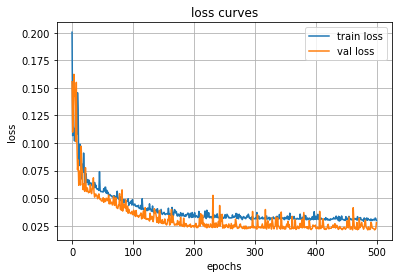

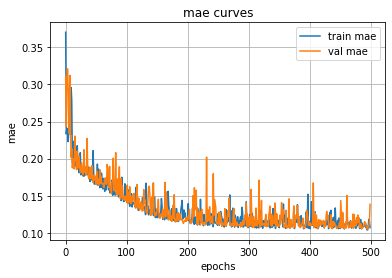

printing the model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 flipout_dense (FlipoutDense  (None, 1)                18        
 )                                                               
                                                                 
Total params: 234
Trainable params: 234
Non-trainable params: 0
_________________________________________________________________
Intermediate samples shape  (20, 3000, 1)
prediction mean :
 [[0.7558962 ]
 [0.41783246]
 [0.5699

In [9]:
def train_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob, train_batch_size, validation_batch_size, test_batch_size):
    K.clear_session()
    
    num_batches = x_train.shape[0] / 32
    kl_weight = 1.0 / num_batches
    prior_params = {
        'prior_sigma_1': 5.0, 
        'prior_sigma_2': 2.0, 
        'prior_pi': 0.5
    }

    model = Sequential()
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(FlipoutDense(1, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='relu'))

    
    #THE FOLLOWING MODEL WORKS REASONABLY WELL  
    #model = Sequential()
    #model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='relu'))
    #model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='relu'))

    #model.add(FlipoutDense(16, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='relu'))
    #model.add(FlipoutDense(16, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='relu'))

    #model.add(FlipoutDense(1, kl_weight, **prior_params, prior=False, bias_distribution=True, activation='relu'))

    #-------------------------
    #model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="relu", input_shape=(8,)))
    #model.add(FlipoutDense(32, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="relu"))
    #model.add(FlipoutDense(1, kl_weight, **prior_params, prior=False, bias_distribution=True, activation="linear"))

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

    history = model.fit(x_train, 
                        y_train, 
                        batch_size=train_batch_size,
                        validation_data=(x_val, y_val), 
                        validation_batch_size=validation_batch_size,
                        verbose=2,
                        epochs=epochs)

    # plotting the training and validation curves
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.show()

    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('mae')
    plt.title('mae curves')
    plt.show()

    print('printing the model summary') 
    
    model.summary()
    model.save(os.path.join(path, 'saved_models', 'model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5'))
    st_model = StochasticRegressor(model)
    pred_samples, pred_mean, pred_std = st_model.predict_output(x_test, batch_size=test_batch_size, num_samples=num_samples)

    return pred_samples, pred_mean, pred_std, st_model

epochs=500
num_samples=20
train_batch_size=4096*2
validation_batch_size=4096*2
test_batch_size=4096*2
prob=0.1
# running this command creates the stochastic flipout model, trains it and generates the predicted_mean and predicted_std for the test set (all 3000 examples)
prediction_samples, prediction_mean, prediction_std, stochastic_model = train_model(train_data, 
                                                                                    train_labels, 
                                                                                    val_data, 
                                                                                    val_labels, 
                                                                                    test_data, 
                                                                                    epochs=epochs, 
                                                                                    num_samples=num_samples, 
                                                                                    prob=prob,
                                                                                    train_batch_size=train_batch_size,
                                                                                    validation_batch_size=validation_batch_size,
                                                                                    test_batch_size=test_batch_size
                                                                                    )
print('prediction mean :\n', prediction_mean)
print('prediction mean shape ', prediction_mean.shape)
print('prediction std :\n', prediction_std)
print('prediction std shape ', prediction_std.shape)
print('prediction samples :\n', prediction_samples)
print('prediction samples shape ', prediction_samples.shape)

## Ground Truth vs prediction plot

In [10]:
# Analysis of the input
num_of_samples_to_be_explained = 1
start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_samples_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)

pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_data, num_samples=num_samples)
print('pred samples shape ', pred_samples.shape)
print('pred mean shape ', pred_mean.shape)
print('pred std shape ', pred_std.shape)

print('pred samples : \n ', pred_samples)
print('pred mean : \n ', pred_mean)
print('pred std : \n ', pred_std)

start_index :  924
test_input shape : (1, 8)
test_input_adj shape : (1, 8, 1)
Intermediate samples shape  (20, 3000, 1)
pred samples shape  (20, 3000, 1)
pred mean shape  (3000, 1)
pred std shape  (3000, 1)
pred samples : 
  [[[0.7738838 ]
  [0.51639044]
  [0.4932058 ]
  ...
  [0.18790913]
  [0.27640393]
  [1.1896486 ]]

 [[0.72390896]
  [0.46565184]
  [0.67704356]
  ...
  [0.24726816]
  [0.2349906 ]
  [1.0849416 ]]

 [[0.7130266 ]
  [0.41621444]
  [0.4941895 ]
  ...
  [0.2071467 ]
  [0.21250002]
  [1.235038  ]]

 ...

 [[0.7591792 ]
  [0.41028258]
  [0.4836994 ]
  ...
  [0.23573463]
  [0.16149169]
  [0.9078218 ]]

 [[0.75040287]
  [0.45211247]
  [0.6355244 ]
  ...
  [0.20351556]
  [0.3406301 ]
  [1.0611782 ]]

 [[0.6656275 ]
  [0.38624844]
  [0.50165474]
  ...
  [0.29615942]
  [0.17631179]
  [0.95706314]]]
pred mean : 
  [[0.72730994]
 [0.41355577]
 [0.57415146]
 ...
 [0.19512466]
 [0.2444267 ]
 [1.0210946 ]]
pred std : 
  [[0.05854043]
 [0.05615785]
 [0.05502452]
 ...
 [0.05445388]
 

indices to be plotted 
 range(0, 100)


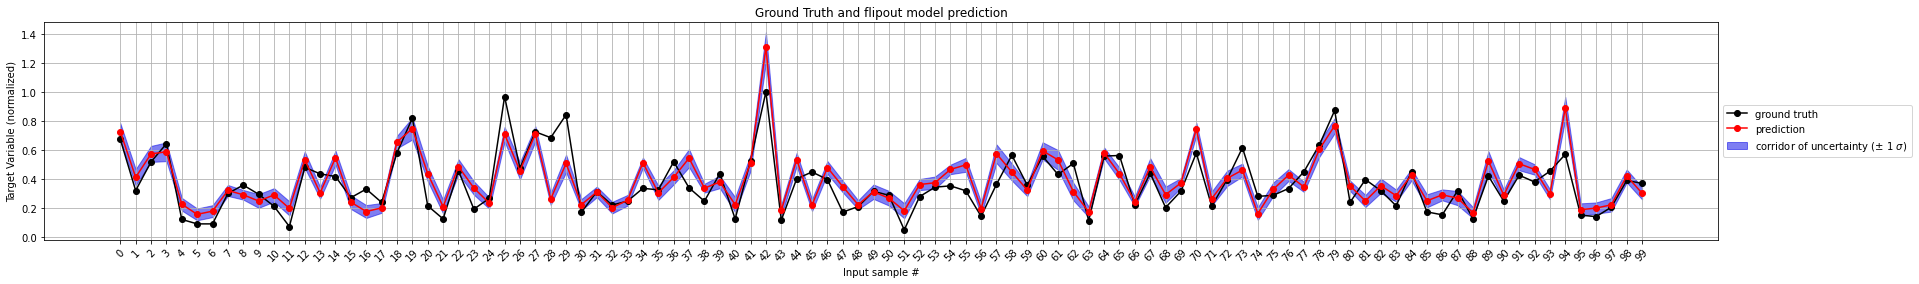

In [11]:
start_index = np.random.randint(test_data.shape[0]-150)
#random = range(start_index, start_index+100)
random = range(0, 100)
print('indices to be plotted \n', random)

test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_gt_vs_prediction', random, uncert_name)